In [ ]:
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1269 (delta 0), reused 7 (delta 0), pack-reused 1252
Receiving objects: 100% (1269/1269), 41.94 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (714/714), done.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models/')
sys.path.append('leaf-disease-classification-kaggle/')

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn, optim
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from fastai.torch_core import apply_init
from functools import partial
import wandb

from src.core import *
from src.lightning.core import *
from src.layers import *
from src.mixmethods import *
from src.networks import *

In [ ]:
seed = seed_everything(42)
idx  = generate_random_id()

In [ ]:
# configure the training paramters/job
config = {
 "random_seed": seed,
 "unique_idx" : idx,
    
 # name of the Wandb project name
 "project_name" : "kaggle-leaf-disease-v2",
    
 # current fold of data to take as validation, other folds are used as
 # train data
 "curr_fold" : 0 ,
 # path to where the images are present
 "image_dir" : "../input/cassava-leaf-disease-classification/train_images/",
 # path to the stratified 5 folds csv data for cassava
 "csv_path"  : "leaf-disease-classification-kaggle/data/stratified-data-5folds.csv",
    
 # settings for the model architecture
 "encoder"   : "resnext50_32x4d",
 "activation": nn.ReLU(inplace=True),
 "image_dims": 512,
    
 # settings for the training job
 "num_epochs": 30,
    
 # Adam parameters from https://docs.fast.ai/optimizer.html#Adam
 "opt_func"  : partial(optim.AdamW, weight_decay=1e-02, eps=1e-05, betas=(0.9, 0.99)),
 "scheduler" : partial(optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=10, T_mult=1),
    
 # when to call scheduler.step() -- "step" or "epoch"
 "scheduler_step" : "step",
 "metric_to_track": None,
    
 "mixmethod" : partial(SnapMix, alpha=5.0, conf_prob=1.0, mid_level=False),
 "loss_func" : LabelSmoothingCrossEntropy(),
    
 "batch_size": 32,
 
 # initial learning rate for the optimizer
 "init_lr": 1e-03,
 "lr_mult": 100,
}

# Albumentations augmentations for train/ valid data
TRAIN_AUGS = A.Compose([
    A.OneOf([
        A.RandomResizedCrop(config["image_dims"], config["image_dims"]), 
        A.CenterCrop(config["image_dims"], config["image_dims"])], 
    p=0.7),
    A.Resize(config["image_dims"], config["image_dims"], p=1.0),
    A.OneOf([A.ShiftScaleRotate(), A.HorizontalFlip()], p=0.8),
    A.OneOf([A.RandomBrightnessContrast(), A.HueSaturationValue()], p=0.5),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)
])
    
VALID_AUGS = A.Compose([
    A.CenterCrop(config["image_dims"], config["image_dims"], p=1.0),
    A.Resize(config["image_dims"], config["image_dims"], p=1.0), 
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

MODEL_SAVE_PATH = f"{config['encoder']}-fold={config['curr_fold']}-{idx}.pt"

In [ ]:
# initate the model architecture
# for snapmix we will call BasicTransferLearningModel class to init a model
# suitable for snapmix, we can also use TransferLearningModel class to init
# a model similar to the model created by the fast.ai cnn_learner func

encoder = timm.create_model(config["encoder"], pretrained=True)
model = SnapMixTransferLearningModel(encoder=encoder, c=len(idx2lbl), 
                                    cut=-2, act=config["activation"])

# init the weights of the final untrained layer
apply_init(model.fc, torch.nn.init.kaiming_normal_)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


In [ ]:
print(model)

SnapMixTransferLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
# init the LightingDataModule + LightningModule
dm = CassavaLightningDataModule(config["csv_path"], config["image_dir"], 
                                curr_fold=config["curr_fold"], 
                                train_augs=TRAIN_AUGS, 
                                valid_augs=VALID_AUGS, 
                                bs=config["batch_size"], 
                                num_workers=4)

litModel = LightningCassava(model,opt_func=config["opt_func"],
                        lr=config["init_lr"], lr_mult=config["lr_mult"],
                        step_after=config["scheduler_step"],
                        scheduler=config["scheduler"],
                        loss_func=config["loss_func"],
                        mixmethod=config["mixmethod"], 
                        metric_to_track=config["metric_to_track"])

Mixmethod : functools.partial(<class 'src.mixmethods.SnapMix'>, alpha=5.0, conf_prob=1.0, mid_level=False)
Loss Function : LabelSmoothingCrossEntropy()


In [ ]:
# initialize pytorch_lightning Trainer + Callbacks
callbacks = [
    pl.callbacks.LearningRateMonitor("step"), 
    WandbImageClassificationCallback(dm),
]

chkpt_callback = pl.callbacks.ModelCheckpoint(monitor="valid/acc",
                                              save_top_k=1,
                                              mode='max')

wb_logger = pl.loggers.WandbLogger(project=config["project_name"])

trainer = pl.Trainer(gpus=1, precision=16, log_every_n_steps=1,
                    gradient_clip_val=0, accumulate_grad_batches=3,
                    max_epochs=config["num_epochs"], callbacks=callbacks,
                    checkpoint_callback=chkpt_callback, logger=wb_logger,
                    deterministic=True, default_root_dir="/kaggle/working/")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Generating data for fold: 0
Using functools.partial(<class 'torch.optim.adamw.AdamW'>, weight_decay=0.01, eps=1e-05, betas=(0.9, 0.99))
Using functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>, T_0=10, T_mult=1)

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | SnapMixTransferLearningModel | 23.0 M
leaf-disease-classification-kaggle/src/mixmethods.py:143: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clslogit = F.softmax(clsw.forward(poolfea))


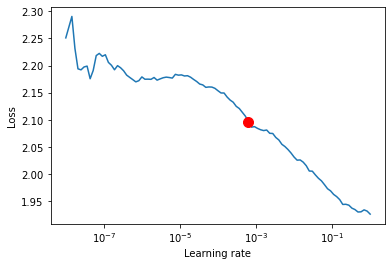

In [ ]:
# start learning_rate finder to find optimum starting Lr
lr_finder = trainer.tuner.lr_find(litModel, datamodule=dm)

fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# modify the initial learning rate 
litModel.hparams['lr'] = 1e-03

# start the training job
trainer.fit(litModel, datamodule=dm)

Using functools.partial(<class 'torch.optim.adamw.AdamW'>, weight_decay=0.01, eps=1e-05, betas=(0.9, 0.99))
Using functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'>, T_0=10, T_mult=1)
wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)



  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | SnapMixTransferLearningModel | 23.0 M


leaf-disease-classification-kaggle/src/mixmethods.py:143: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clslogit = F.softmax(clsw.forward(poolfea))


wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'train/loss_step': 1.5626304149627686, 'train/acc_step': 0.78125, 'epoch': 2}.
wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'train/loss_step': 1.8353142738342285, 'train/acc_step': 0.65625, 'epoch': 2}.
wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 180 < 181; dropping {'train/loss_step': 1.4762122631072998, 'train/acc_step': 0.6875, 'epoch': 2}.


wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'train/loss_step': 1.6031370162963867, 'train/acc_step': 0.53125, 'epoch': 3}.
wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'train/loss_step': 1.7638871669769287, 'train/acc_step': 0.59375, 'epoch': 3}.
wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 359 < 360; dropping {'train/loss_step': 1.6682155132293701, 'train/acc_step': 0.65625, 'epoch': 3}.


wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'train/loss_step': 1.5889679193496704, 'train/acc_step': 0.78125, 'epoch': 4}.
wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'train/loss_step': 1.864989995956421, 'train/acc_step': 0.46875, 'epoch': 4}.
wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 538 < 539; dropping {'train/loss_step': 1.530360221862793, 'train/acc_step': 0.8125, 'epoch': 4}.


wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'train/loss_step': 1.6057534217834473, 'train/acc_step': 0.78125, 'epoch': 5}.
wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'train/loss_step': 1.4858930110931396, 'train/acc_step': 0.6875, 'epoch': 5}.
wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 717 < 718; dropping {'train/loss_step': 1.3329057693481445, 'train/acc_step': 0.59375, 'epoch': 5}.


wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'train/loss_step': 1.7223092317581177, 'train/acc_step': 0.53125, 'epoch': 6}.
wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'train/loss_step': 1.569311499595642, 'train/acc_step': 0.59375, 'epoch': 6}.
wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 896 < 897; dropping {'train/loss_step': 1.5710110664367676, 'train/acc_step': 0.53125, 'epoch': 6}.


wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'train/loss_step': 1.6816432476043701, 'train/acc_step': 0.5, 'epoch': 7}.
wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'train/loss_step': 1.4872058629989624, 'train/acc_step': 0.71875, 'epoch': 7}.
wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1075 < 1076; dropping {'train/loss_step': 1.6813397407531738, 'train/acc_step': 0.6875, 'epoch': 7}.


wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'train/loss_step': 1.7587594985961914, 'train/acc_step': 0.6875, 'epoch': 8}.
wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'train/loss_step': 1.7445330619812012, 'train/acc_step': 0.625, 'epoch': 8}.
wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 1254 < 1255; dropping {'train/loss_step': 1.6616582870483398, 'train/acc_step': 0.625, 'epoch': 8}.


wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'train/loss_step': 1.661999225616455, 'train/acc_step': 0.65625, 'epoch': 9}.
wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'train/loss_step': 1.461803674697876, 'train/acc_step': 0.6875, 'epoch': 9}.
wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 1433 < 1434; dropping {'train/loss_step': 1.4751070737838745, 'train/acc_step': 0.78125, 'epoch': 9}.


wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'train/loss_step': 1.7594172954559326, 'train/acc_step': 0.625, 'epoch': 10}.
wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'train/loss_step': 1.6155195236206055, 'train/acc_step': 0.6875, 'epoch': 10}.
wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 1612 < 1613; dropping {'train/loss_step': 1.5021036863327026, 'train/acc_step': 0.65625, 'epoch': 10}.


wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'train/loss_step': 1.5440902709960938, 'train/acc_step': 0.5625, 'epoch': 11}.
wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'train/loss_step': 1.5446653366088867, 'train/acc_step': 0.59375, 'epoch': 11}.
wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 1791 < 1792; dropping {'train/loss_step': 1.3323227167129517, 'train/acc_step': 0.59375, 'epoch': 11}.


wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'train/loss_step': 1.5589752197265625, 'train/acc_step': 0.6875, 'epoch': 12}.
wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'train/loss_step': 1.4388246536254883, 'train/acc_step': 0.84375, 'epoch': 12}.
wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 1970 < 1971; dropping {'train/loss_step': 1.546117901802063, 'train/acc_step': 0.71875, 'epoch': 12}.


wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'train/loss_step': 1.5257680416107178, 'train/acc_step': 0.59375, 'epoch': 13}.
wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'train/loss_step': 1.4855331182479858, 'train/acc_step': 0.78125, 'epoch': 13}.
wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 2149 < 2150; dropping {'train/loss_step': 1.5947749614715576, 'train/acc_step': 0.6875, 'epoch': 13}.


wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'train/loss_step': 1.6107748746871948, 'train/acc_step': 0.6875, 'epoch': 14}.
wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'train/loss_step': 1.3125252723693848, 'train/acc_step': 0.875, 'epoch': 14}.
wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 2328 < 2329; dropping {'train/loss_step': 1.401749610900879, 'train/acc_step': 0.875, 'epoch': 14}.


wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'train/loss_step': 1.786037564277649, 'train/acc_step': 0.65625, 'epoch': 15}.
wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'train/loss_step': 1.5681862831115723, 'train/acc_step': 0.71875, 'epoch': 15}.
wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 2507 < 2508; dropping {'train/loss_step': 1.6750836372375488, 'train/acc_step': 0.75, 'epoch': 15}.


wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'train/loss_step': 1.468625545501709, 'train/acc_step': 0.875, 'epoch': 16}.
wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'train/loss_step': 1.5951200723648071, 'train/acc_step': 0.625, 'epoch': 16}.
wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 2686 < 2687; dropping {'train/loss_step': 1.5832377672195435, 'train/acc_step': 0.78125, 'epoch': 16}.


wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'train/loss_step': 1.4786264896392822, 'train/acc_step': 0.75, 'epoch': 17}.
wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'train/loss_step': 1.390223741531372, 'train/acc_step': 0.8125, 'epoch': 17}.
wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 2865 < 2866; dropping {'train/loss_step': 1.525599718093872, 'train/acc_step': 0.8125, 'epoch': 17}.


wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'train/loss_step': 1.49702787399292, 'train/acc_step': 0.71875, 'epoch': 18}.
wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'train/loss_step': 1.3730013370513916, 'train/acc_step': 0.6875, 'epoch': 18}.
wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 3044 < 3045; dropping {'train/loss_step': 1.4963178634643555, 'train/acc_step': 0.71875, 'epoch': 18}.


wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'train/loss_step': 1.5619075298309326, 'train/acc_step': 0.6875, 'epoch': 19}.
wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'train/loss_step': 1.4213199615478516, 'train/acc_step': 0.8125, 'epoch': 19}.
wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 3223 < 3224; dropping {'train/loss_step': 1.5374177694320679, 'train/acc_step': 0.65625, 'epoch': 19}.


wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'train/loss_step': 1.3939943313598633, 'train/acc_step': 0.65625, 'epoch': 20}.
wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'train/loss_step': 1.3911795616149902, 'train/acc_step': 0.75, 'epoch': 20}.
wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'lr-AdamW/pg1': 9.755282581475769e-06, 'lr-AdamW/pg2': 0.0009755282581475768}.
wandb: WARNING Step must only increase in log calls.  Step 3402 < 3403; dropping {'train/loss_step': 1.5169868469238281, 'train/acc_step': 0.625, 'epoch': 20}.


wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'train/loss_step': 1.49934983253479, 'train/acc_step': 0.65625, 'epoch': 21}.
wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'train/loss_step': 1.5798404216766357, 'train/acc_step': 0.65625, 'epoch': 21}.
wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'lr-AdamW/pg1': 1e-05, 'lr-AdamW/pg2': 0.001}.
wandb: WARNING Step must only increase in log calls.  Step 3581 < 3582; dropping {'train/loss_step': 1.4751964807510376, 'train/acc_step': 0.71875, 'epoch': 21}.


wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'train/loss_step': 1.531130313873291, 'train/acc_step': 0.78125, 'epoch': 22}.
wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'train/loss_step': 1.5147755146026611, 'train/acc_step': 0.53125, 'epoch': 22}.
wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'lr-AdamW/pg1': 2.447174185242324e-07, 'lr-AdamW/pg2': 2.4471741852423235e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3760 < 3761; dropping {'train/loss_step': 1.4672091007232666, 'train/acc_step': 0.6875, 'epoch': 22}.


wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'train/loss_step': 1.4314351081848145, 'train/acc_step': 0.65625, 'epoch': 23}.
wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'train/loss_step': 1.5669951438903809, 'train/acc_step': 0.65625, 'epoch': 23}.
wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'lr-AdamW/pg1': 9.549150281252633e-07, 'lr-AdamW/pg2': 9.549150281252633e-05}.
wandb: WARNING Step must only increase in log calls.  Step 3939 < 3940; dropping {'train/loss_step': 1.4506306648254395, 'train/acc_step': 0.78125, 'epoch': 23}.


wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'train/loss_step': 1.4361999034881592, 'train/acc_step': 0.6875, 'epoch': 24}.
wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'train/loss_step': 1.4448857307434082, 'train/acc_step': 0.625, 'epoch': 24}.
wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'lr-AdamW/pg1': 2.061073738537635e-06, 'lr-AdamW/pg2': 0.00020610737385376348}.
wandb: WARNING Step must only increase in log calls.  Step 4118 < 4119; dropping {'train/loss_step': 1.5325572490692139, 'train/acc_step': 0.71875, 'epoch': 24}.


wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'train/loss_step': 1.6304645538330078, 'train/acc_step': 0.6875, 'epoch': 25}.
wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'train/loss_step': 1.381197214126587, 'train/acc_step': 0.78125, 'epoch': 25}.
wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'lr-AdamW/pg1': 3.4549150281252635e-06, 'lr-AdamW/pg2': 0.00034549150281252633}.
wandb: WARNING Step must only increase in log calls.  Step 4297 < 4298; dropping {'train/loss_step': 1.515650749206543, 'train/acc_step': 0.625, 'epoch': 25}.


wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'train/loss_step': 1.3170220851898193, 'train/acc_step': 0.78125, 'epoch': 26}.
wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'train/loss_step': 1.7811986207962036, 'train/acc_step': 0.5625, 'epoch': 26}.
wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'lr-AdamW/pg1': 5e-06, 'lr-AdamW/pg2': 0.0005}.
wandb: WARNING Step must only increase in log calls.  Step 4476 < 4477; dropping {'train/loss_step': 1.6817737817764282, 'train/acc_step': 0.625, 'epoch': 26}.


wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'train/loss_step': 1.4018418788909912, 'train/acc_step': 0.8125, 'epoch': 27}.
wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'train/loss_step': 1.5579805374145508, 'train/acc_step': 0.65625, 'epoch': 27}.
wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'lr-AdamW/pg1': 6.545084971874738e-06, 'lr-AdamW/pg2': 0.0006545084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 4655 < 4656; dropping {'train/loss_step': 1.9395077228546143, 'train/acc_step': 0.4375, 'epoch': 27}.


wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'train/loss_step': 1.5669538974761963, 'train/acc_step': 0.6875, 'epoch': 28}.
wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'train/loss_step': 1.5259389877319336, 'train/acc_step': 0.71875, 'epoch': 28}.
wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'lr-AdamW/pg1': 7.938926261462366e-06, 'lr-AdamW/pg2': 0.0007938926261462366}.
wandb: WARNING Step must only increase in log calls.  Step 4834 < 4835; dropping {'train/loss_step': 1.5194671154022217, 'train/acc_step': 0.65625, 'epoch': 28}.


wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'train/loss_step': 1.67506742477417, 'train/acc_step': 0.53125, 'epoch': 29}.
wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'train/loss_step': 1.4566072225570679, 'train/acc_step': 0.65625, 'epoch': 29}.
wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'lr-AdamW/pg1': 9.045084971874738e-06, 'lr-AdamW/pg2': 0.0009045084971874737}.
wandb: WARNING Step must only increase in log calls.  Step 5013 < 5014; dropping {'train/loss_step': 1.4555819034576416, 'train/acc_step': 0.75, 'epoch': 29}.


1

In [ ]:
# automatically loads in the best model weights
# according to metric in checkpoint callback
results = trainer.test(litModel, datamodule=dm)

wandb: WARNING Step must only increase in log calls.  Step 5192 < 5193; dropping {'valid/loss': 0.8122750520706177, 'valid/acc': 0.7964953184127808, 'test/acc': 0.7964953184127808, 'test/loss': 0.8122750520706177, 'epoch': 29}.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': tensor(0.7965, device='cuda:0'),
 'test/loss': tensor(0.8123, device='cuda:0'),
 'train/acc': tensor(0.6897, device='cuda:0'),
 'train/acc_epoch': tensor(0.7120, device='cuda:0'),
 'train/acc_step': tensor(0.6897, device='cuda:0'),
 'train/loss': tensor(1.5469, device='cuda:0'),
 'train/loss_epoch': tensor(1.5101, device='cuda:0'),
 'train/loss_step': tensor(1.5469, device='cuda:0'),
 'valid/acc': tensor(0.7965, device='cuda:0'),
 'valid/loss': tensor(0.8123, device='cuda:0')}
--------------------------------------------------------------------------------



In [ ]:
# save the weights of the model
litModel.save_model_weights(MODEL_SAVE_PATH)

weights saved to resnext50_32x4d-fold=0-1f25c028.pt


In [ ]:
# upload model weights to wandb server and
# finish the wandb run
wandb.save(MODEL_SAVE_PATH)
wandb.finish()

lr-AdamW/pg1,1e-05
lr-AdamW/pg2,0.001
train/loss_step,1.54694
train/acc_step,0.68966
epoch,29
_step,5192
_runtime,19097
_timestamp,1609037485
valid/loss,0.81228
valid/acc,0.7965
train/loss_epoch,1.51007


lr-AdamW/pg1,▇▇█▁▂▃▄▆▇██▁▂▃▄▆▇██▁▂▃▄▇▇██▂▂▃▆▇▇█▁▂▂▄▆▂
lr-AdamW/pg2,▇▇█▁▂▃▄▆▇██▁▂▃▄▆▇██▁▂▃▄▇▇██▂▂▃▆▇▇█▁▂▂▄▆▂
train/loss_step,▇▄▆▅▅▅▅▂▃▇▅▅▄▃█▃▅▂▃█▄▄▄▂▃█▃▄▄▄▇▄▂▄▅▇▁▅▆▅
train/acc_step,▃▅▃▆▆▂▆▆▇▂▅▄▅▄▄▆▇▆▅▃▇▅▅▅▅▃▇▇▄▃▁▅▅▆▄▂█▄▄▅
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/loss,█▆▅▄▄▃▃▃▂▂▂▂▃▃▂▂▂▁▂▂▁▁▂▁▂▂▁▁▁
valid/acc,▁▂▆▅▅▆▇▇▇▇▇▇▆▅▇█▇█▇██▇▇▇▇███▇
train/loss_epoch,█▄▄▃▂▃▃▂▂▂▃▂▂▂▂▂▁▃▂▁▂▁▁▂▂▂▁▁▁
